# Trial phase characterization

In [4]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# --Machine learning and statistics+
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase

one = ONE()


## Parameters

In [5]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [40]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    #session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    #mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1new_version'
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    
    # Keep only first 90 trials
    # design_matrix = design_matrix.loc[(design_matrix['Bin'] > time_trial_90 * 10) & (design_matrix['Bin'] < time_trial_180 * 10) & (design_matrix['Bin'] > session_start * 10)]
    # design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

In [41]:
use_data = design_matrix.copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])
use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

## Trial phase

In [42]:
bins_df = bins_per_trial_phase(use_data, session_trials)
bins_df = bins_df.rename(columns={0: 'Bin'})
new_df = design_matrix.merge(bins_df, on='Bin')
melted = pd.melt(new_df, id_vars=['Bin', 'label', 'Trial'], value_vars=np.array(new_df.keys()[1:-1]))

/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:410: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:412: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/Users/ineslaranjeira/Documents/Repositories/representation_learnin

## Trial epoch

In [43]:
new_df['broader_label'] = new_df['label']
new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'Post-choice'

<Axes: xlabel='label', ylabel='value'>

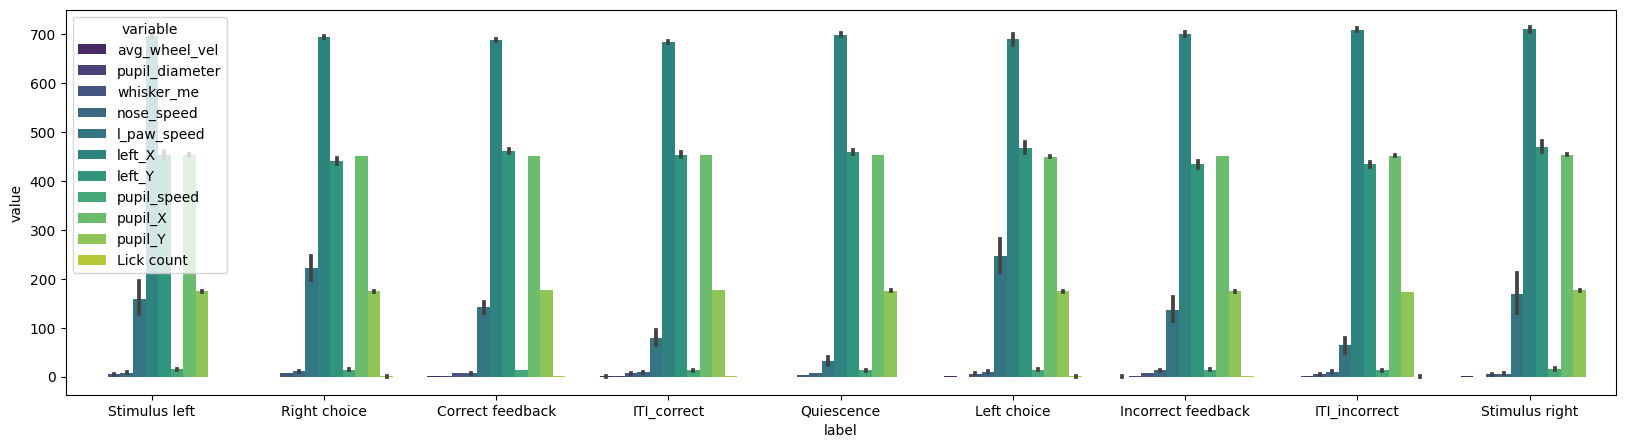

In [25]:
fig, ax = plt.subplots(figsize=[20, 5])
sns.barplot(hue='variable', y='value', x='label', data=melted, palette='viridis')
#plt.ylim([-5, 5])

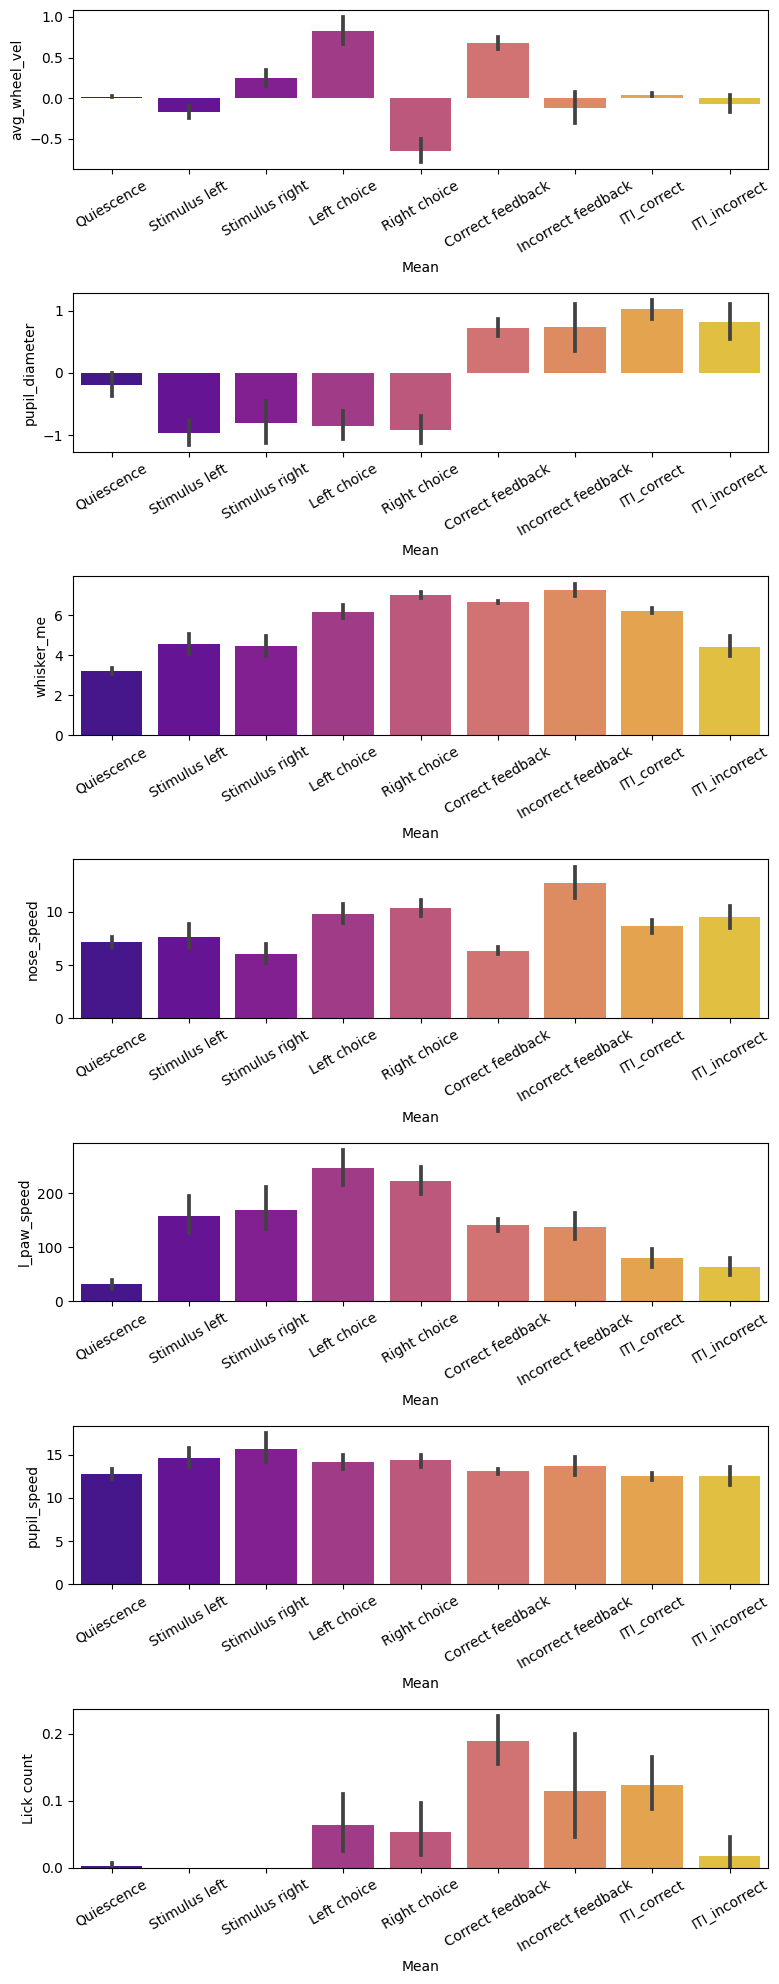

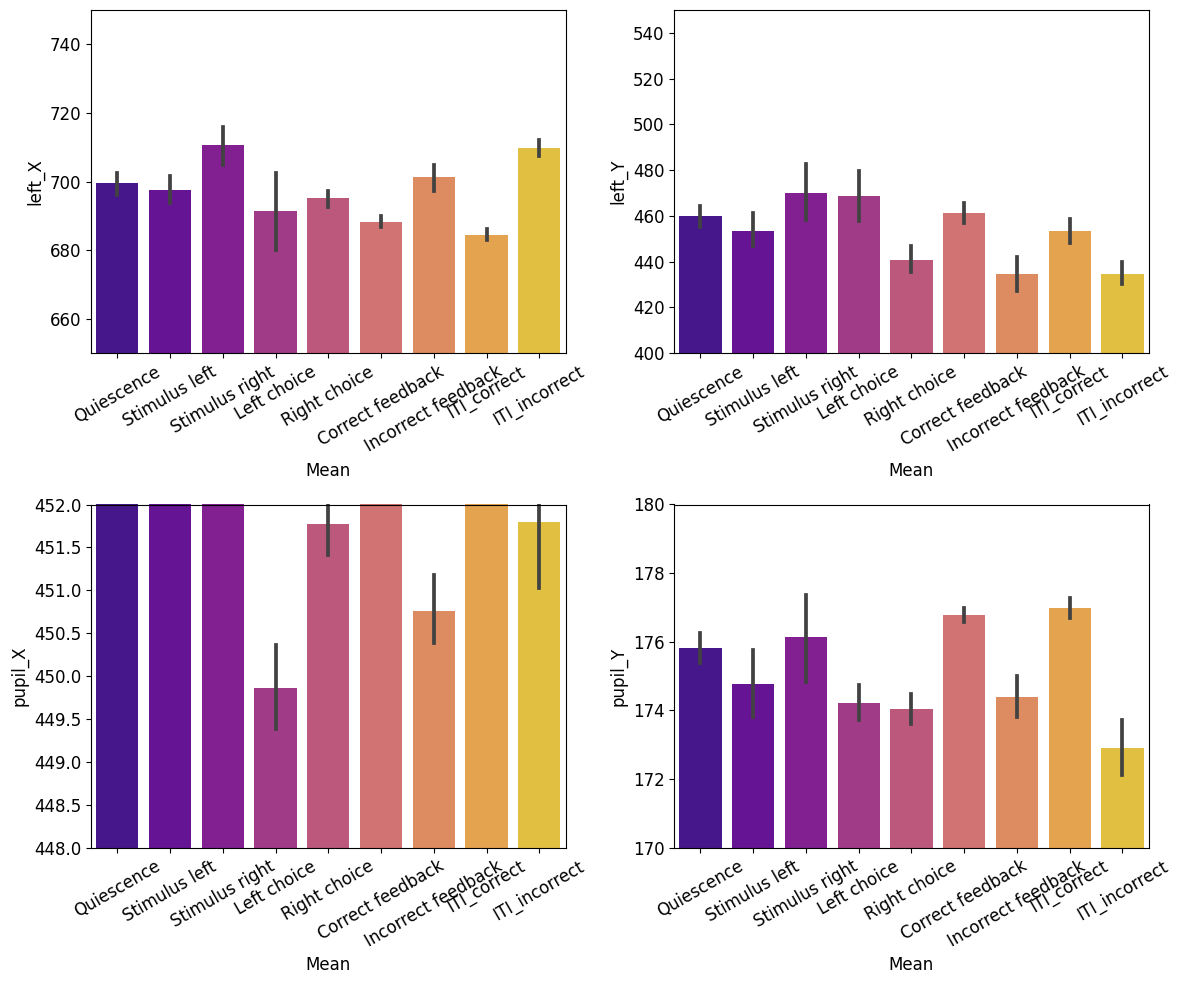

In [26]:
trial_epochs = new_df['label'].unique()

# Plot some variables
first_vars = ['avg_wheel_vel',
 'pupil_diameter',
 'whisker_me',
 'nose_speed',
 'l_paw_speed',
 'pupil_speed',
 'Lick count']

fig, ax = plt.subplots(nrows=len(first_vars) , ncols=1, sharex=False, sharey=False, figsize=[8, 20])
plt.rc('font', size=12)

for v, var in enumerate(first_vars):
    use_data = new_df[['Bin', 'label', var]]
    sns.barplot(y=var, x='label', data=use_data, ax=ax[v], palette='plasma', order = ['Quiescence', 'Stimulus left', 'Stimulus right', 
                                                                                      'Left choice', 'Right choice', 'Correct feedback', 
                                                                                      'Incorrect feedback', 'ITI_correct', 'ITI_incorrect'])
    ax[v].set_xlabel('Mean')
    ax[v].set_xticklabels(['Quiescence', 'Stimulus left', 'Stimulus right', 'Left choice', 'Right choice', 'Correct feedback', 
                                                                                      'Incorrect feedback', 'ITI_correct', 'ITI_incorrect'], rotation=30)

    #ax[v].set_ylim([np.min(use_data[var]), np.max(use_data[var])])
plt.tight_layout()
plt.show()

pos_vars = [ 'left_X',
 'left_Y',
 'pupil_X',
 'pupil_Y',]
fig, ax = plt.subplots(nrows=2 , ncols=2, sharex=False, sharey=False, figsize=[12, 10])
plt.rc('font', size=12)

for v, var in enumerate(pos_vars):
    
    use_data = new_df[['Bin', 'label', var]]

    if var == 'left_X':
        axis = ax[0, 0]
        ymin = 650
        ymax = 750
    elif var == 'left_Y':
        axis = ax[0, 1]
        ymin = 400
        ymax = 550
    elif var == 'pupil_X':
        axis = ax[1, 0]
        ymin = 448
        ymax = 452
    elif var == 'pupil_Y':
        axis = ax[1, 1]
        ymin = 170
        ymax = 180
        
    sns.barplot(y=var, x='label', data=use_data, ax=axis, palette='plasma', order = ['Quiescence', 'Stimulus left', 'Stimulus right', 
                                                                                    'Left choice', 'Right choice', 'Correct feedback', 
                                                                                    'Incorrect feedback', 'ITI_correct', 'ITI_incorrect'])
    axis.set_xlabel('Mean')
    axis.set_xticklabels(['Quiescence', 'Stimulus left', 'Stimulus right', 'Left choice', 'Right choice', 'Correct feedback', 
                                                                                    'Incorrect feedback', 'ITI_correct', 'ITI_incorrect'], rotation=30)

    axis.set_ylim([ymin, ymax])
    
plt.tight_layout()
plt.show()

## PCA on data samples

In [44]:
"""
PRINCIPLE COMPONENT ANALYSES
"""

X = matrix_all[mat][0] # (n_samples, n_features)
#X = np.array(design_matrix)

# Mean centered and equal variance (redundant code)
scaler = StandardScaler()
scaler.fit(X)

pca = PCA() # svd_solver='full'
#pca.fit(scaler.transform(X))
X_reduced = pca.fit_transform(scaler.transform(X))
#X_reduced = pca.fit_transform(X)


Text(0, 0.5, '% Variance explained')

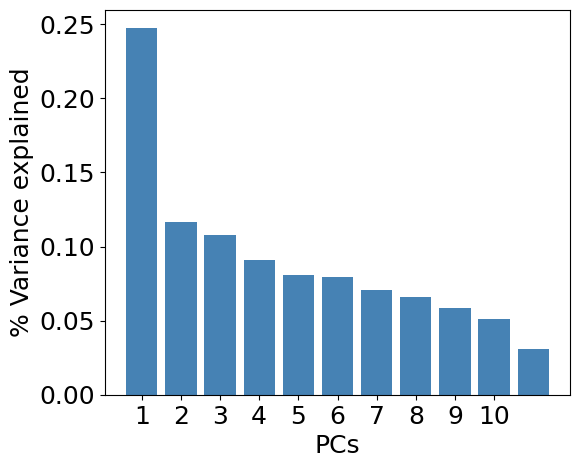

In [45]:
# Plot variance explained per principle component
fig, ax = plt.subplots(figsize=[6,5])
plt.rc('font', size=18)
keep_pc = np.shape(X)[1]
plt.bar(np.arange(1, keep_pc+1, 1), pca.explained_variance_ratio_[0:keep_pc], color='steelblue')
plt.xticks(np.arange(1, keep_pc, 1))
#plt.xlim([0, 3])
plt.xlabel('PCs')
plt.ylabel('% Variance explained')

### Get bin information

In [46]:
# Plot projections of datapoints into first 3 principal components
augmented_data = pd.DataFrame(columns=['Bin'], index=range(len(X_reduced)))
augmented_data['Bin'] = design_matrix['Bin']
augmented_data['pc1'] = X_reduced[:, 0].transpose()
augmented_data['pc2'] = X_reduced[:, 1].transpose()
augmented_data['pc3'] = X_reduced[:, 2].transpose()
augmented_data['pc4'] = X_reduced[:, 3].transpose()
augmented_data['pc5'] = X_reduced[:, 4].transpose()
augmented_data['pc6'] = X_reduced[:, 5].transpose()
augmented_data['pc7'] = X_reduced[:, 6].transpose()
augmented_data['pc8'] = X_reduced[:, 7].transpose()
augmented_data['pc9'] = X_reduced[:, 8].transpose()
augmented_data['pc10'] = X_reduced[:, 9].transpose()

In [47]:
augmented = augmented_data.merge(melted[['Bin', 'label', 'Trial']].drop_duplicates(), on='Bin')

augmented['broader_label'] = augmented['label']
augmented.loc[augmented['broader_label']=='Stimulus right', 'broader_label'] = 'Pre-choice'
augmented.loc[augmented['broader_label']=='Stimulus left', 'broader_label'] = 'Pre-choice'
augmented.loc[augmented['broader_label']=='Quiescence', 'broader_label'] = 'Pre-choice'
augmented.loc[augmented['broader_label']=='Left choice', 'broader_label'] = 'Choice'
augmented.loc[augmented['broader_label']=='Right choice', 'broader_label'] = 'Choice'
augmented.loc[augmented['broader_label']=='Correct feedback', 'broader_label'] = 'Post-choice'
augmented.loc[augmented['broader_label']=='Incorrect feedback', 'broader_label'] = 'Post-choice'
augmented.loc[augmented['broader_label']=='ITI_correct', 'broader_label'] = 'Post-choice'
augmented.loc[augmented['broader_label']=='ITI_incorrect', 'broader_label'] = 'Post-choice'

(0.0, 100.0)

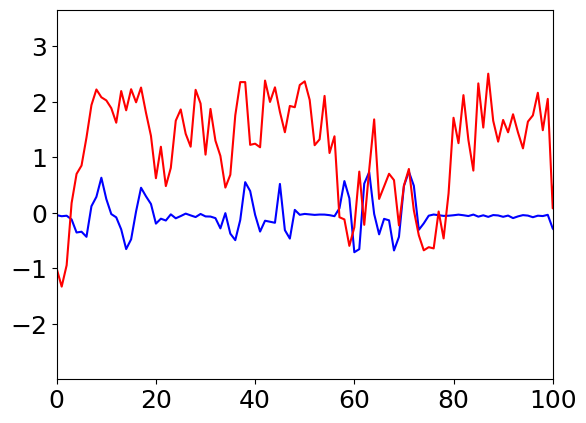

In [48]:
plt.plot(X[:, 0], color='blue')
plt.plot(augmented['pc1'], color='red')
plt.xlim([0, 100])


In [49]:
def group_per_phase(data, label = 'broader_label'):

    """ Get trial classes """
    # Mean per label
    mean_label = pd.DataFrame(data.groupby(['label', 'Trial'])['pc1', 'pc2'].mean())
    mean_label = mean_label.reset_index(level=[0,1])

    # Get correct and incorrect, left and right trials
    trials_correct = mean_label.loc[mean_label['label']=='Correct feedback', 'Trial']
    trials_incorrect = mean_label.loc[mean_label['label']=='Incorrect feedback', 'Trial']
    trials_left = mean_label.loc[mean_label['label']=='Left choice', 'Trial']
    trials_right = mean_label.loc[mean_label['label']=='Right choice', 'Trial']

    correct_left = np.intersect1d(trials_correct, trials_left)
    correct_right = np.intersect1d(trials_correct, trials_right)
    incorrect_left = np.intersect1d(trials_incorrect, trials_left)
    incorrect_right = np.intersect1d(trials_incorrect, trials_right)

    correct_left_data = data.loc[data['Trial'].isin(correct_left)]
    incorrect_left_data = data.loc[data['Trial'].isin(incorrect_left)]
    correct_right_data = data.loc[data['Trial'].isin(correct_right)]
    incorrect_right_data = data.loc[data['Trial'].isin(incorrect_right)]

    """ Mean per label per trial """
    mean_trial = pd.DataFrame(data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
    mean_trial = mean_trial.reset_index(level=[0, 1])

    # Mean per label
    correct_left_data_mean = pd.DataFrame(correct_left_data.groupby([label])['pc1', 'pc2'].mean())
    correct_left_data_mean = correct_left_data_mean.reset_index(level=[0])
    incorrect_left_data_mean = pd.DataFrame(incorrect_left_data.groupby([label])['pc1', 'pc2'].mean())
    incorrect_left_data_mean = incorrect_left_data_mean.reset_index(level=[0])
    correct_right_data_mean = pd.DataFrame(correct_right_data.groupby([label])['pc1', 'pc2'].mean())
    correct_right_data_mean = correct_right_data_mean.reset_index(level=[0])
    incorrect_right_data_mean = pd.DataFrame(incorrect_right_data.groupby([label])['pc1', 'pc2'].mean())
    incorrect_right_data_mean = incorrect_right_data_mean.reset_index(level=[0])

    # Mean per label per trial
    correct_left_data = pd.DataFrame(correct_left_data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
    correct_left_data = correct_left_data.reset_index(level=[0, 1])
    incorrect_left_data = pd.DataFrame(incorrect_left_data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
    incorrect_left_data = incorrect_left_data.reset_index(level=[0, 1])
    correct_right_data = pd.DataFrame(correct_right_data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
    correct_right_data = correct_right_data.reset_index(level=[0, 1])
    incorrect_right_data = pd.DataFrame(incorrect_right_data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
    incorrect_right_data = incorrect_right_data.reset_index(level=[0, 1])

    if label == 'broader_label':
        sort_dict = {'Pre-choice':0,'Choice':1,'Post-choice':2}
    elif label=='label':
        sort_dict = {'Quiescence':0,'Stimulus left':1, 'Stimulus right': 2, 
                     'Left choice': 3, 'Right choice': 4, 'Correct feedback': 5,
                     'Incorrect feedback': 6, 'ITI_correct': 7, 'ITI_incorrect': 8,
                     }
    correct_left_data_mean = correct_left_data_mean.iloc[correct_left_data_mean[label].map(sort_dict).sort_values().index]
    correct_right_data_mean = correct_right_data_mean.iloc[correct_right_data_mean[label].map(sort_dict).sort_values().index]
    incorrect_left_data_mean = incorrect_left_data_mean.iloc[incorrect_left_data_mean[label].map(sort_dict).sort_values().index]
    incorrect_right_data_mean = incorrect_right_data_mean.iloc[incorrect_right_data_mean[label].map(sort_dict).sort_values().index]

    grouped = [correct_left_data, incorrect_left_data, correct_right_data, incorrect_right_data]
    grouped_mean = [correct_left_data_mean, incorrect_left_data_mean, correct_right_data_mean, incorrect_right_data_mean]

    return grouped, grouped_mean

### Plot trials overlaid on PC space

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86990/49267083.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(data.groupby(['label', 'Trial'])['pc1', 'pc2'].mean())
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86990/49267083.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_trial = pd.DataFrame(data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86990/49267083.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  correct_left_data_mean = pd.DataFrame(correct_left_data.groupby([label])['pc1', 'pc2'].mean())
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86990/49267083.py:31: FutureWarning: Indexing with multiple key

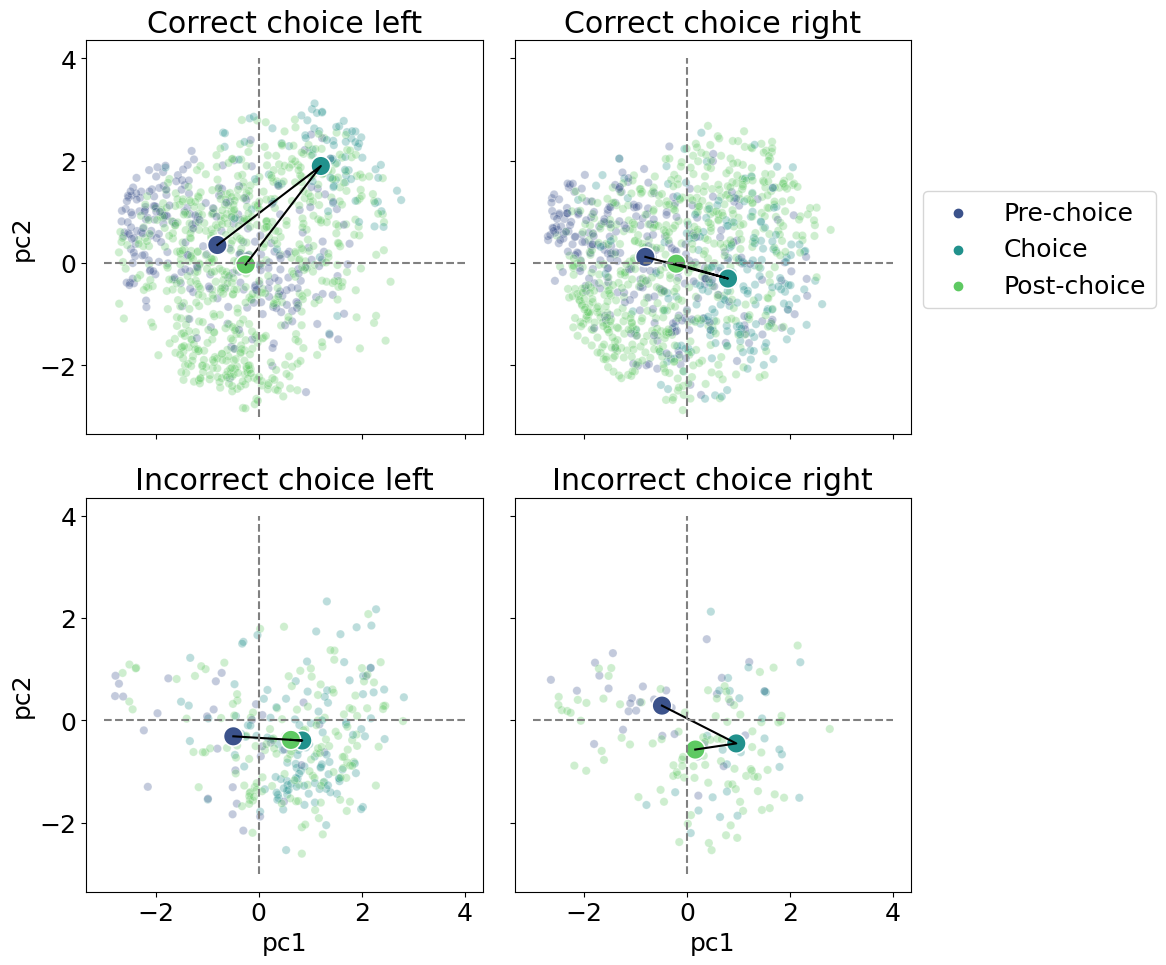

In [34]:
trials = augmented['Trial'].unique()
label = 'broader_label'
#label = 'label'

fig, axs = plt.subplots(nrows=2 , ncols=2, sharex=True, sharey=True, figsize=[12, 10])

for t, trial in enumerate(trials):

    use_data = augmented.loc[augmented['Trial']==trial]
    trial_data_pc1 = augmented.loc[augmented['Trial']==trial, 'pc1']
    trial_data_pc2 = augmented.loc[augmented['Trial']==trial, 'pc2']
    
    if ('Correct feedback' in np.array(use_data['label'])) & ('Left choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[0, 0]) # s=200
        #axs[0, 0].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    elif ('Correct feedback' in np.array(use_data['label'])) & ('Right choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[0, 1]) # s=200
        #axs[0, 1].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    elif ('Incorrect feedback' in np.array(use_data['label'])) & ('Left choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[1, 0]) # s=200
        #axs[1, 0].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    elif ('Incorrect feedback' in np.array(use_data['label'])) & ('Right choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[1, 1]) # s=200
        #axs[1, 1].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    

    axs[0, 0].set_title('Correct choice left')
    axs[0, 1].set_title('Correct choice right')
    axs[1, 0].set_title('Incorrect choice left')
    axs[1, 1].set_title('Incorrect choice right')

grouped, grouped_mean = group_per_phase(augmented, label)

correct_left_data = grouped[0]
incorrect_left_data = grouped[1]
correct_right_data = grouped[2]
incorrect_right_data = grouped[3]

correct_left_data_mean = grouped_mean[0]
incorrect_left_data_mean = grouped_mean[1]
correct_right_data_mean = grouped_mean[2]
incorrect_right_data_mean = grouped_mean[3]
    
axs[0, 0].plot(np.array(correct_left_data_mean['pc1']), np.array(correct_left_data_mean['pc2']), color='Black') 
axs[0, 1].plot(np.array(correct_right_data_mean['pc1']), np.array(correct_right_data_mean['pc2']), color='Black') 
axs[1, 0].plot(np.array(incorrect_left_data_mean['pc1']), np.array(incorrect_left_data_mean['pc2']), color='Black') 
axs[1, 1].plot(np.array(incorrect_right_data_mean['pc1']), np.array(incorrect_right_data_mean['pc2']), color='Black') 

sns.scatterplot(x='pc1', y='pc2', data=correct_left_data_mean, alpha=1, hue=label, legend=None, palette='viridis', ax=axs[0, 0], s=200)
sns.scatterplot(x='pc1', y='pc2', data=correct_right_data_mean, alpha=1, hue=label, palette='viridis', ax=axs[0, 1], s=200)
axs[0, 1].legend(loc='upper left', bbox_to_anchor=(1, 0.65))
sns.scatterplot(x='pc1', y='pc2', data=incorrect_left_data_mean, alpha=1, hue=label, legend=None, palette='viridis', ax=axs[1, 0], s=200)
sns.scatterplot(x='pc1', y='pc2', data=incorrect_right_data_mean, alpha=1, hue=label, legend=None, palette='viridis', ax=axs[1, 1], s=200)

# Create grid
axs[0, 0].vlines(0, -3, 4, color='Gray', linestyles='--')
axs[0, 0].hlines(0, -3, 4, color='Gray', linestyles='--')
axs[0, 1].vlines(0, -3, 4, color='Gray', linestyles='--')
axs[0, 1].hlines(0, -3, 4, color='Gray', linestyles='--')
axs[1, 0].vlines(0, -3, 4, color='Gray', linestyles='--')
axs[1, 0].hlines(0, -3, 4, color='Gray', linestyles='--')
axs[1, 1].vlines(0, -3, 4, color='Gray', linestyles='--')
axs[1, 1].hlines(0, -3, 4, color='Gray', linestyles='--')

plt.tight_layout()
plt.show()


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86990/49267083.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(data.groupby(['label', 'Trial'])['pc1', 'pc2'].mean())
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86990/49267083.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_trial = pd.DataFrame(data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86990/49267083.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  correct_left_data_mean = pd.DataFrame(correct_left_data.groupby([label])['pc1', 'pc2'].mean())
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86990/49267083.py:31: FutureWarning: Indexing with multiple key

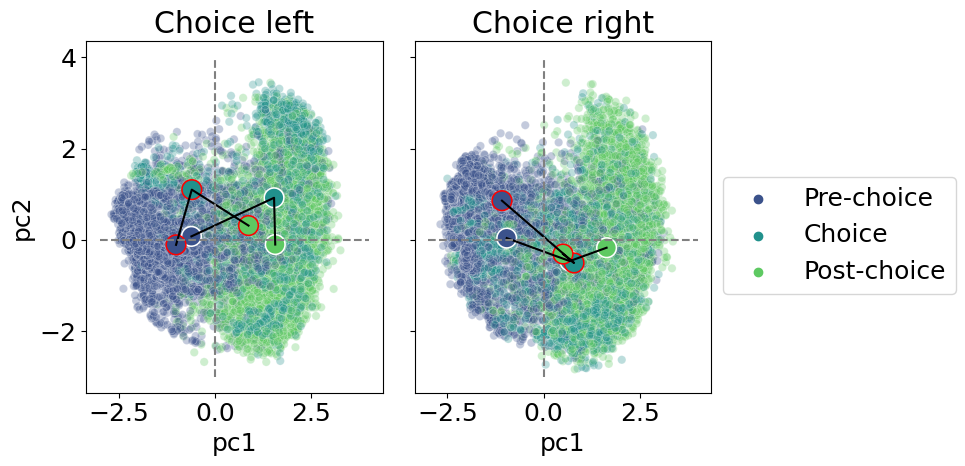

In [51]:
trials = augmented['Trial'].unique()
label = 'broader_label'

fig, axs = plt.subplots(nrows=1 , ncols=2, sharex=True, sharey=True, figsize=[10, 5])

for t, trial in enumerate(trials):

    use_data = augmented.loc[augmented['Trial']==trial]
    trial_data_pc1 = augmented.loc[augmented['Trial']==trial, 'pc1']
    trial_data_pc2 = augmented.loc[augmented['Trial']==trial, 'pc2']
    
    if ('Correct feedback' in np.array(use_data['label'])) & ('Left choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[0]) # s=200
        #axs[0, 0].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    elif ('Correct feedback' in np.array(use_data['label'])) & ('Right choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[1]) # s=200
        #axs[0, 1].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    elif ('Incorrect feedback' in np.array(use_data['label'])) & ('Left choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[0]) # s=200
        #axs[1, 0].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    elif ('Incorrect feedback' in np.array(use_data['label'])) & ('Right choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[1]) # s=200
        #axs[1, 1].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    
    axs[0].set_title('Choice left')
    axs[1].set_title('Choice right')

grouped, grouped_mean = group_per_phase(augmented, label)

correct_left_data = grouped[0]
incorrect_left_data = grouped[1]
correct_right_data = grouped[2]
incorrect_right_data = grouped[3]

correct_left_data_mean = grouped_mean[0]
incorrect_left_data_mean = grouped_mean[1]
correct_right_data_mean = grouped_mean[2]
incorrect_right_data_mean = grouped_mean[3]
    
axs[0].plot(np.array(correct_left_data_mean['pc1']), np.array(correct_left_data_mean['pc2']), color='Black') 
axs[1].plot(np.array(correct_right_data_mean['pc1']), np.array(correct_right_data_mean['pc2']), color='Black') 
axs[0].plot(np.array(incorrect_left_data_mean['pc1']), np.array(incorrect_left_data_mean['pc2']), color='Black') 
axs[1].plot(np.array(incorrect_right_data_mean['pc1']), np.array(incorrect_right_data_mean['pc2']), color='Black') 

sns.scatterplot(x='pc1', y='pc2', data=correct_left_data_mean, alpha=1, hue=label, legend=None, palette='viridis', ax=axs[0], s=200)
sns.scatterplot(x='pc1', y='pc2', data=correct_right_data_mean, alpha=1, hue=label, palette='viridis', ax=axs[1], s=200)
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 0.65))
sns.scatterplot(x='pc1', y='pc2', data=incorrect_left_data_mean, alpha=1, hue=label, legend=None, 
                edgecolor='r', palette='viridis', ax=axs[0], s=200)
sns.scatterplot(x='pc1', y='pc2', data=incorrect_right_data_mean, alpha=1, hue=label, legend=None, 
                edgecolor='r', palette='viridis', ax=axs[1], s=200)

# Create grid
axs[0].vlines(0, -3, 4, color='Gray', linestyles='--')
axs[0].hlines(0, -3, 4, color='Gray', linestyles='--')
axs[1].vlines(0, -3, 4, color='Gray', linestyles='--')
axs[1].hlines(0, -3, 4, color='Gray', linestyles='--')

plt.tight_layout()
plt.show()


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86990/49267083.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(data.groupby(['label', 'Trial'])['pc1', 'pc2'].mean())
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86990/49267083.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_trial = pd.DataFrame(data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86990/49267083.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  correct_left_data_mean = pd.DataFrame(correct_left_data.groupby([label])['pc1', 'pc2'].mean())
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86990/49267083.py:31: FutureWarning: Indexing with multiple key

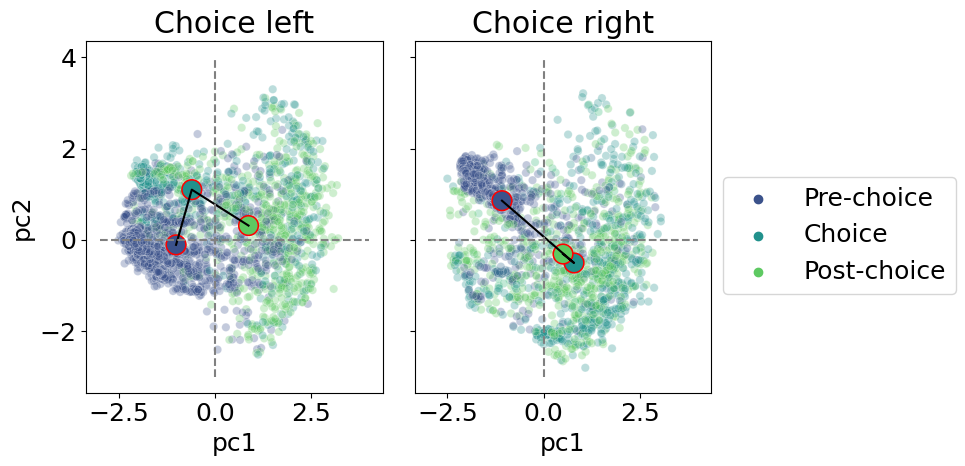

In [58]:
trials = augmented['Trial'].unique()
label = 'broader_label'

fig, axs = plt.subplots(nrows=1 , ncols=2, sharex=True, sharey=True, figsize=[10, 5])

for t, trial in enumerate(trials):

    use_data = augmented.loc[augmented['Trial']==trial]
    trial_data_pc1 = augmented.loc[augmented['Trial']==trial, 'pc1']
    trial_data_pc2 = augmented.loc[augmented['Trial']==trial, 'pc2']
    
    if ('Incorrect feedback' in np.array(use_data['label'])) & ('Left choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[0]) # s=200
        #axs[1, 0].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    elif ('Incorrect feedback' in np.array(use_data['label'])) & ('Right choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[1]) # s=200
        #axs[1, 1].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    
    axs[0].set_title('Choice left')
    axs[1].set_title('Choice right')

grouped, grouped_mean = group_per_phase(augmented, label)

correct_left_data = grouped[0]
incorrect_left_data = grouped[1]
correct_right_data = grouped[2]
incorrect_right_data = grouped[3]

correct_left_data_mean = grouped_mean[0]
incorrect_left_data_mean = grouped_mean[1]
correct_right_data_mean = grouped_mean[2]
incorrect_right_data_mean = grouped_mean[3]


axs[0].plot(np.array(incorrect_left_data_mean['pc1']), np.array(incorrect_left_data_mean['pc2']), color='Black') 
axs[1].plot(np.array(incorrect_right_data_mean['pc1']), np.array(incorrect_right_data_mean['pc2']), color='Black') 

sns.scatterplot(x='pc1', y='pc2', data=incorrect_left_data_mean, alpha=1, hue=label, legend=None,
                edgecolor='r', palette='viridis', ax=axs[0], s=200)
sns.scatterplot(x='pc1', y='pc2', data=incorrect_right_data_mean, alpha=1, hue=label, 
                edgecolor='r', palette='viridis', ax=axs[1], s=200)
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 0.65))

# Create grid
axs[0].vlines(0, -3, 4, color='Gray', linestyles='--')
axs[0].hlines(0, -3, 4, color='Gray', linestyles='--')
axs[1].vlines(0, -3, 4, color='Gray', linestyles='--')
axs[1].hlines(0, -3, 4, color='Gray', linestyles='--')

plt.tight_layout()
plt.show()

/tmp/ipykernel_6789/2061646929.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(augmented.groupby(['label', 'Trial'])['pc1', 'pc2'].mean())
/tmp/ipykernel_6789/2061646929.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_broad_label = pd.DataFrame(augmented.groupby(['broader_label', 'Trial'])['pc1', 'pc2'].mean())
/tmp/ipykernel_6789/2061646929.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  correct_left_data_mean = pd.DataFrame(correct_left_data.groupby(['broader_label'])['pc1', 'pc2'].median())
/tmp/ipykernel_6789/2061646929.py:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  incorrect_left_data_mean = pd.DataFrame(incorrec

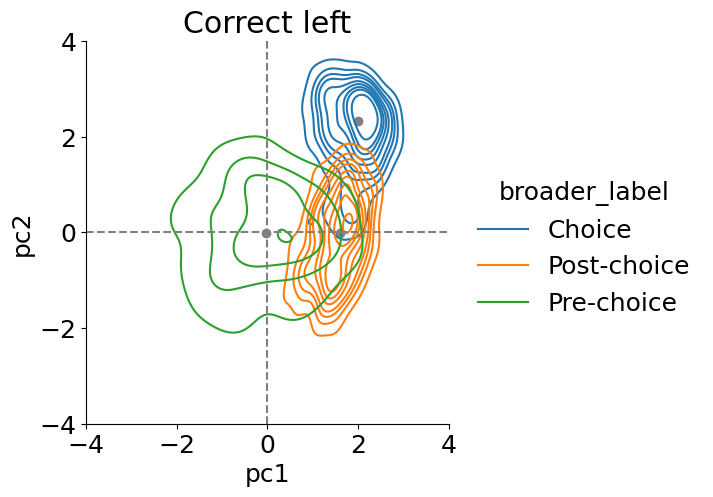

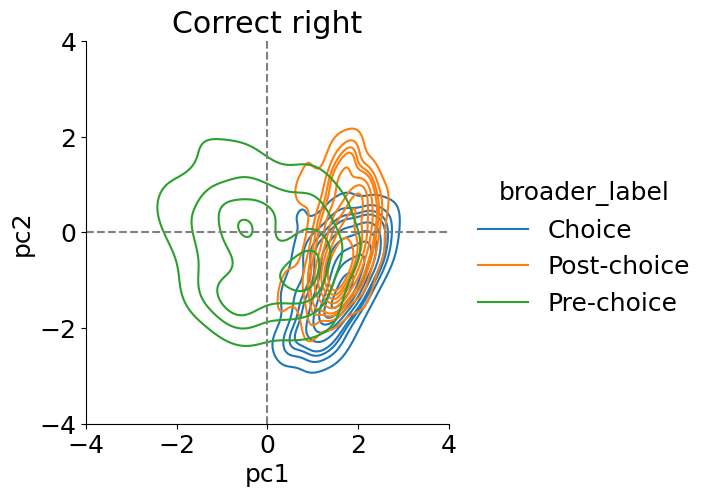

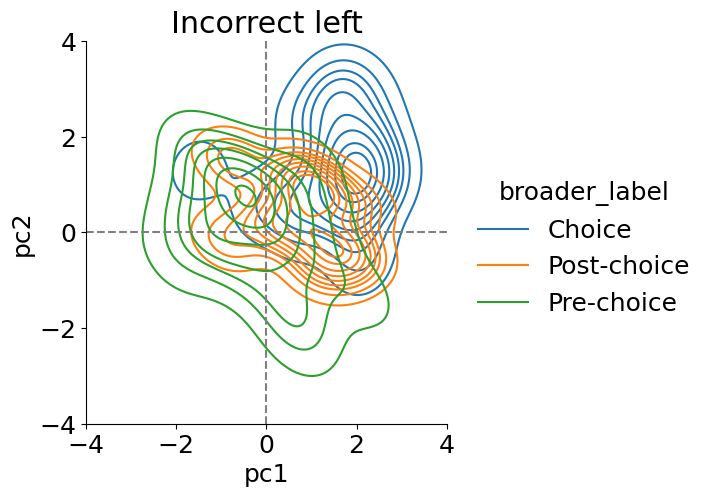

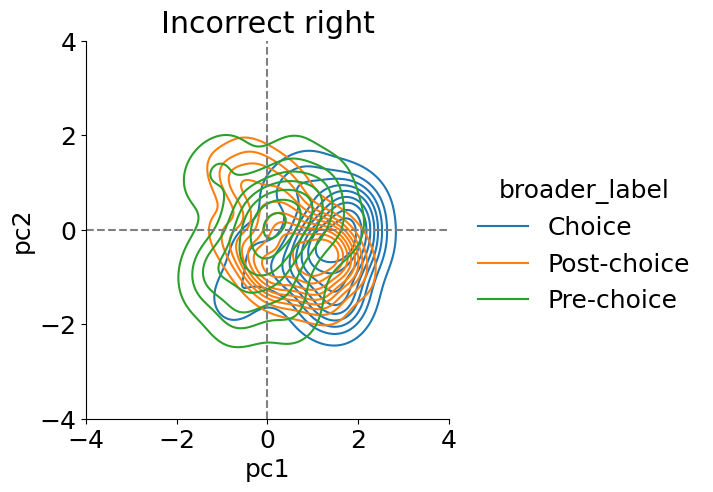

In [71]:
# Plot per broad trial phase - AVERAGE ACROSS TRIALS

grouped, grouped_mean = group_per_phase(augmented)

correct_left_data = grouped[0]
incorrect_left_data = grouped[1]
correct_right_data = grouped[2]
incorrect_right_data = grouped[3]

correct_left_data_mean = grouped_mean[0]
incorrect_left_data_mean = grouped_mean[1]
correct_right_data_mean = grouped_mean[2]
incorrect_right_data_mean = grouped_mean[3]

sns.displot(correct_left_data, x="pc1", y="pc2", hue="broader_label", kind="kde", ax=axs[0, 1])
plt.scatter(np.array(correct_left_data_mean['pc1']), np.array(correct_left_data_mean['pc2']), color='Gray') 
plt.vlines(0, -4, 4, color='Gray', linestyles='--')
plt.hlines(0, -4, 4, color='Gray', linestyles='--')
plt.title('Correct left')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
sns.displot(correct_right_data, x="pc1", y="pc2", hue="broader_label", kind="kde", ax=axs[0, 1])
plt.vlines(0, -4, 4, color='Gray', linestyles='--')
plt.hlines(0, -4, 4, color='Gray', linestyles='--')
plt.title('Correct right')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
sns.displot(incorrect_left_data, x="pc1", y="pc2", hue="broader_label", kind="kde", ax=axs[1, 0])
plt.vlines(0, -4, 4, color='Gray', linestyles='--')
plt.hlines(0, -4, 4, color='Gray', linestyles='--')
plt.title('Incorrect left')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
sns.displot(incorrect_right_data, x="pc1", y="pc2", hue="broader_label", kind="kde", ax=axs[1, 1])
plt.vlines(0, -4, 4, color='Gray', linestyles='--')
plt.hlines(0, -4, 4, color='Gray', linestyles='--')
plt.title('Incorrect right')
plt.xlim([-4, 4])
plt.ylim([-4, 4])


plt.show()


/tmp/ipykernel_9154/2813198358.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_broad_label = pd.DataFrame(augmented.groupby(['label', 'Trial'])['pc1', 'pc2'].mean())
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/home/ine

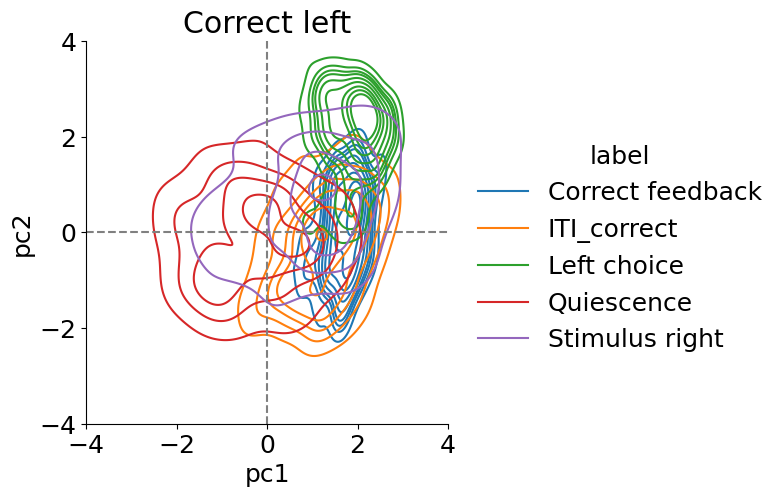

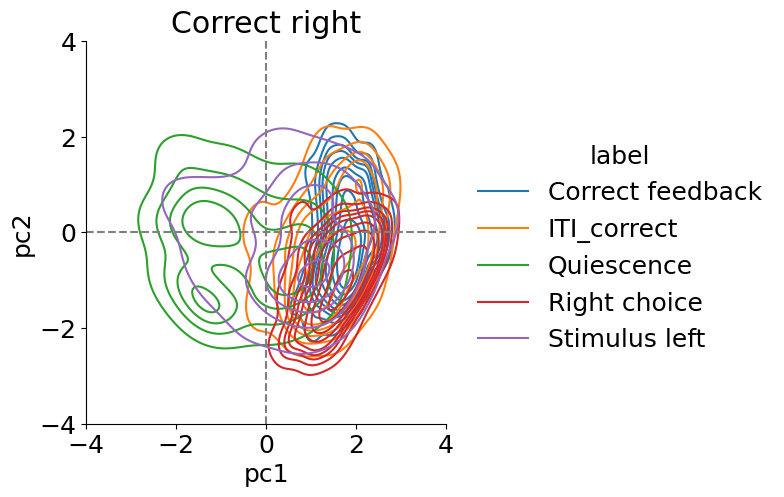

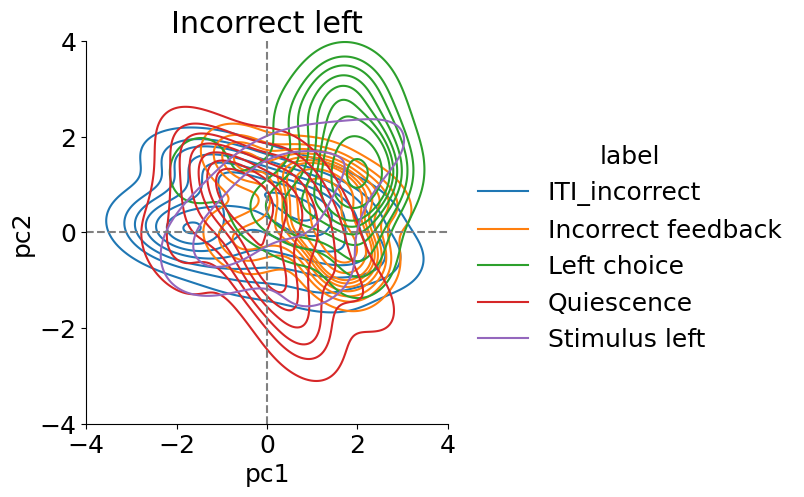

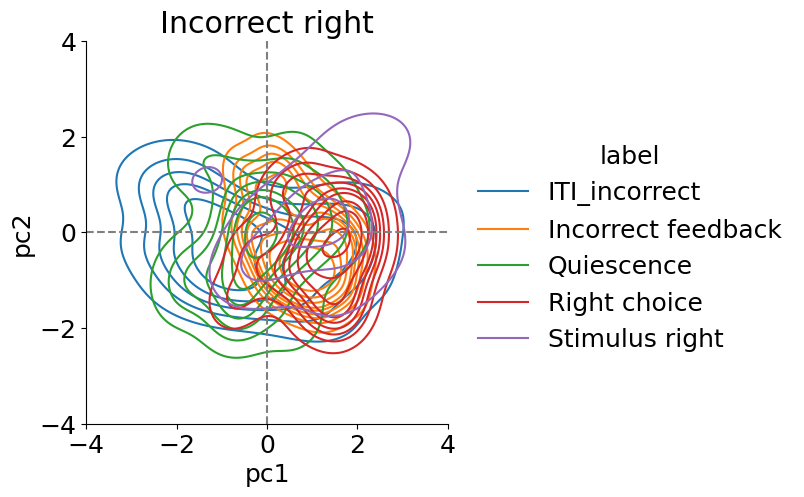

In [105]:
# Plot per broad trial phase

mean_broad_label = pd.DataFrame(augmented.groupby(['label', 'Trial'])['pc1', 'pc2'].mean())
mean_broad_label = mean_broad_label.reset_index(level=[0,1])

correct_left_data = mean_broad_label.loc[mean_broad_label['Trial'].isin(correct_left)]
incorrect_left_data = mean_broad_label.loc[mean_broad_label['Trial'].isin(incorrect_left)]
correct_right_data = mean_broad_label.loc[mean_broad_label['Trial'].isin(correct_right)]
incorrect_right_data = mean_broad_label.loc[mean_broad_label['Trial'].isin(incorrect_right)]


#fig, axs = plt.subplots(nrows=2 , ncols=2, sharex=True, sharey=True, figsize=[12, 10])

sns.displot(correct_left_data, x="pc1", y="pc2", hue="label", kind="kde", ax=axs[0, 0])
plt.vlines(0, -4, 4, color='Gray', linestyles='--')
plt.hlines(0, -4, 4, color='Gray', linestyles='--')
plt.title('Correct left')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
sns.displot(correct_right_data, x="pc1", y="pc2", hue="label", kind="kde", ax=axs[0, 1])
plt.vlines(0, -4, 4, color='Gray', linestyles='--')
plt.hlines(0, -4, 4, color='Gray', linestyles='--')
plt.title('Correct right')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
sns.displot(incorrect_left_data, x="pc1", y="pc2", hue="label", kind="kde", ax=axs[1, 0])
plt.vlines(0, -4, 4, color='Gray', linestyles='--')
plt.hlines(0, -4, 4, color='Gray', linestyles='--')
plt.title('Incorrect left')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
sns.displot(incorrect_right_data, x="pc1", y="pc2", hue="label", kind="kde", ax=axs[1, 1])
plt.vlines(0, -4, 4, color='Gray', linestyles='--')
plt.hlines(0, -4, 4, color='Gray', linestyles='--')
plt.title('Incorrect right')
plt.xlim([-4, 4])
plt.ylim([-4, 4])

plt.show()

    


In [ ]:

use_data = mean_label.loc[mean_label['Trial']==trial]
trial_data_pc1 = mean_label.loc[mean_label['Trial']==trial, 'pc1']
trial_data_pc2 = mean_label.loc[mean_label['Trial']==trial, 'pc2']

if 'Left choice' in np.array(correct_data['label']):
    sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.5, hue='label', palette='viridis', ax=axs[0, 0]) # s=200 legend=None,
    axs[0, 0].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
elif 'Right choice' in np.array(correct['label']):
    sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.5, hue='label', palette='viridis', ax=axs[0, 1]) # s=200
    axs[0, 1].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
elif 'Left choice' in np.array(incorrect['label']):
    sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.5, hue='label', palette='viridis', legend=None, ax=axs[1, 0]) # s=200
    axs[1, 0].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
elif 'Right choice' in np.array(incorrect['label']):
    sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.5, hue='label', palette='viridis', legend=None, ax=axs[1, 1]) # s=200
    axs[1, 1].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 

axs[0, 0].set_title('Correct choice left')
axs[0, 1].set_title('Correct choice right')
axs[1, 0].set_title('Incorrect choice left')
axs[1, 1].set_title('Incorrect choice right')
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.65))
plt.tight_layout()
plt.show()

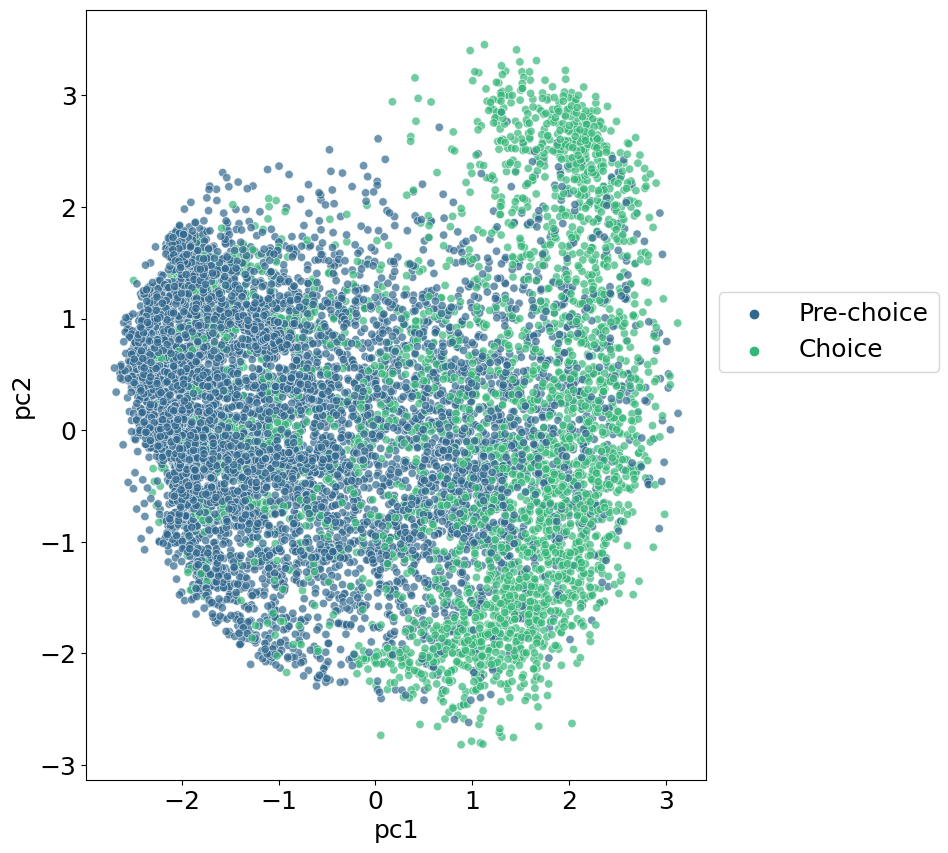

In [29]:
pair = ['Pre-choice', 'Choice']
#pair = ['Choice']
fig, axs = plt.subplots(figsize=[8, 10])
use_data = augmented.loc[augmented['broader_label'].isin(pair)]
sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.7, hue='broader_label', palette='viridis')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.65))


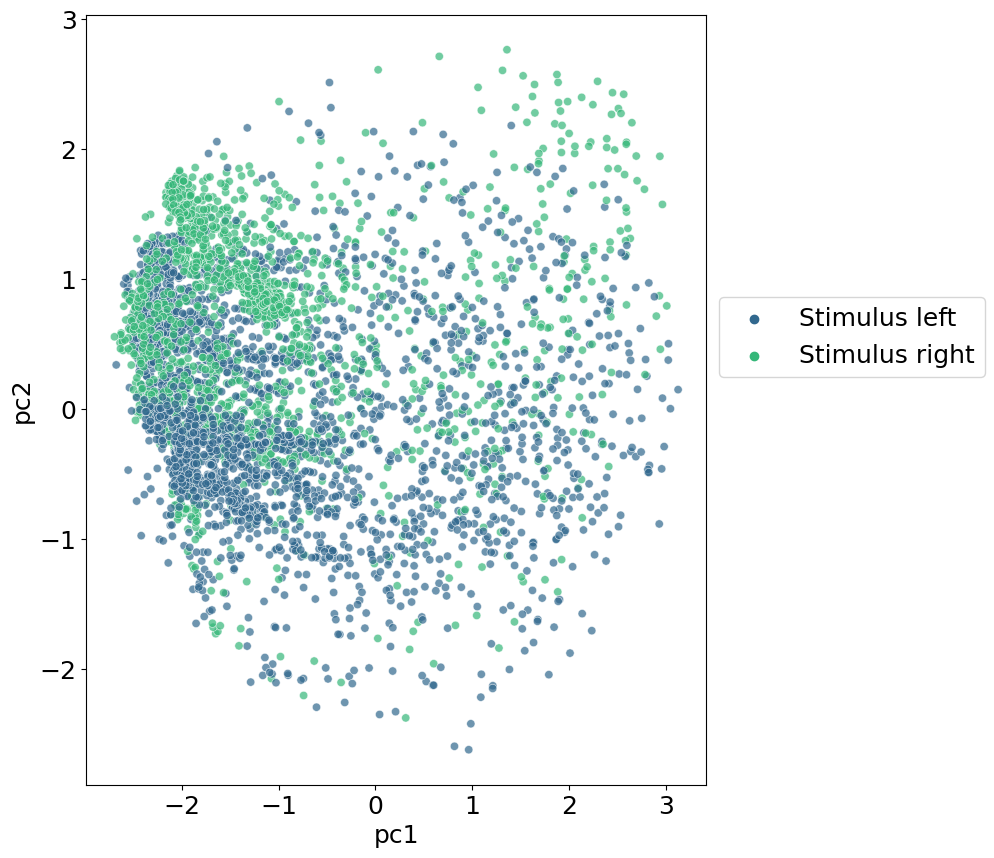

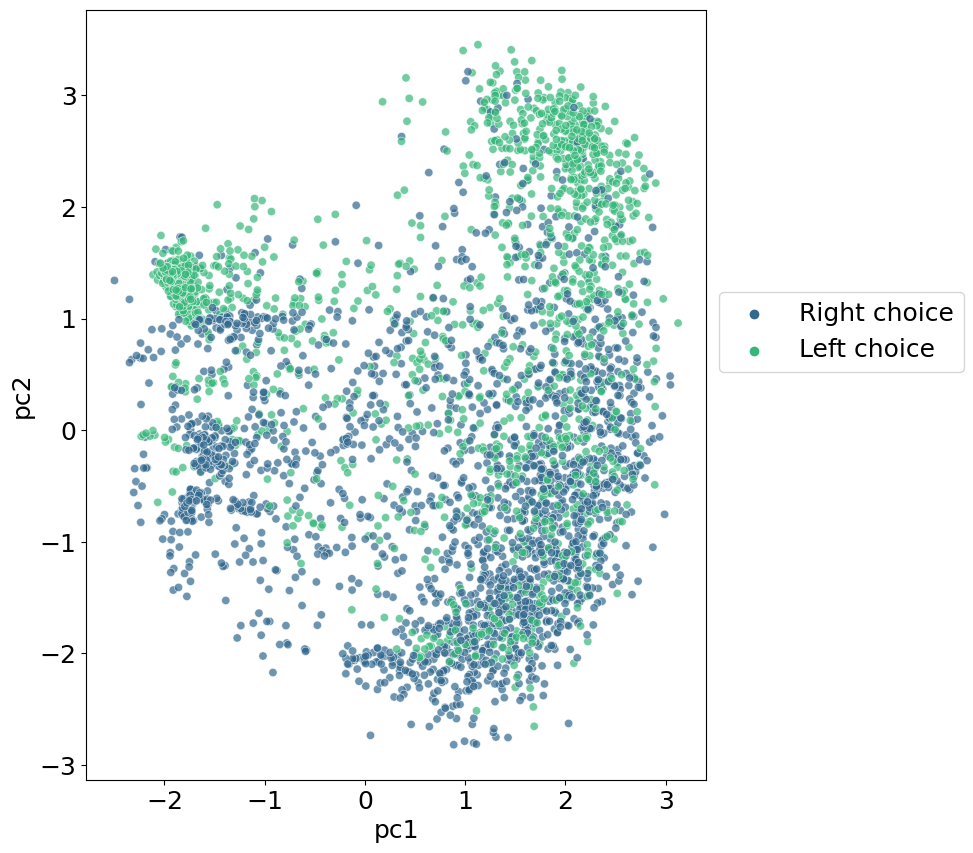

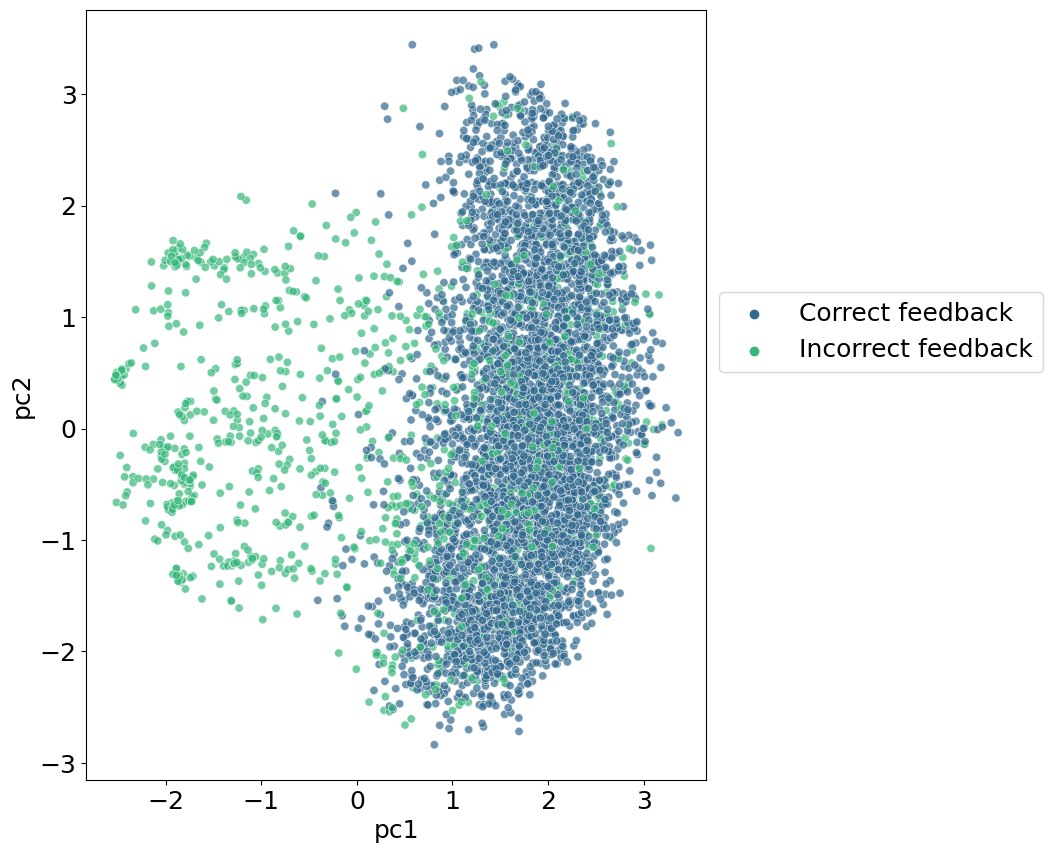

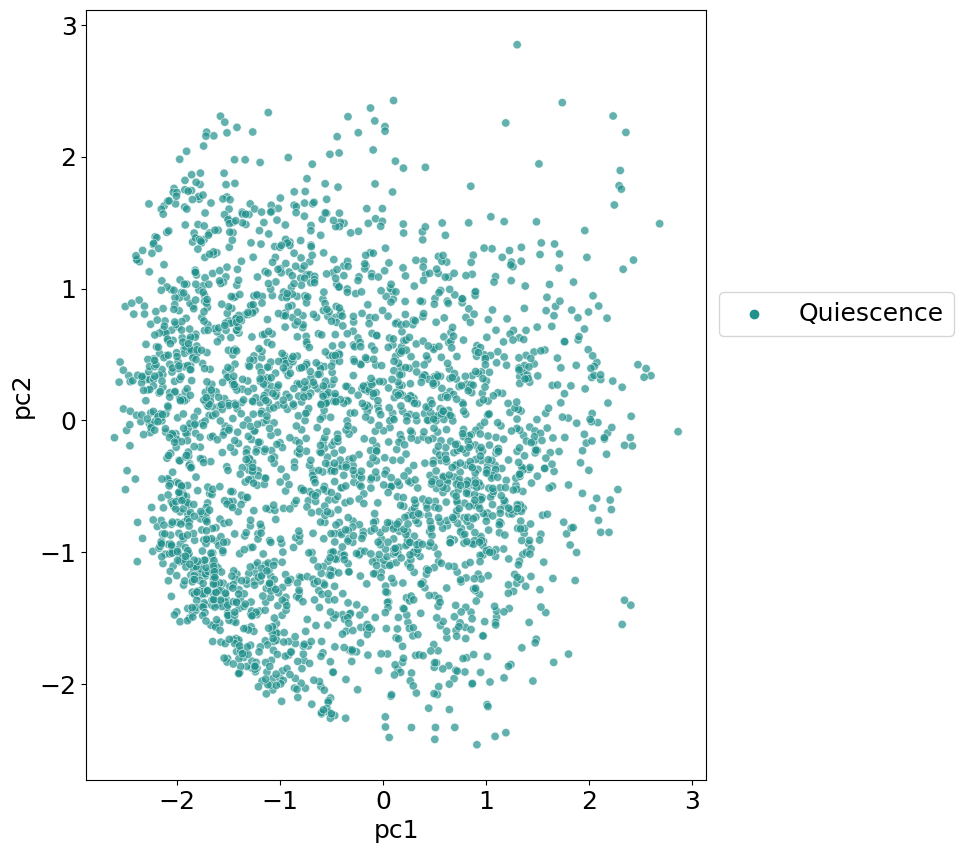

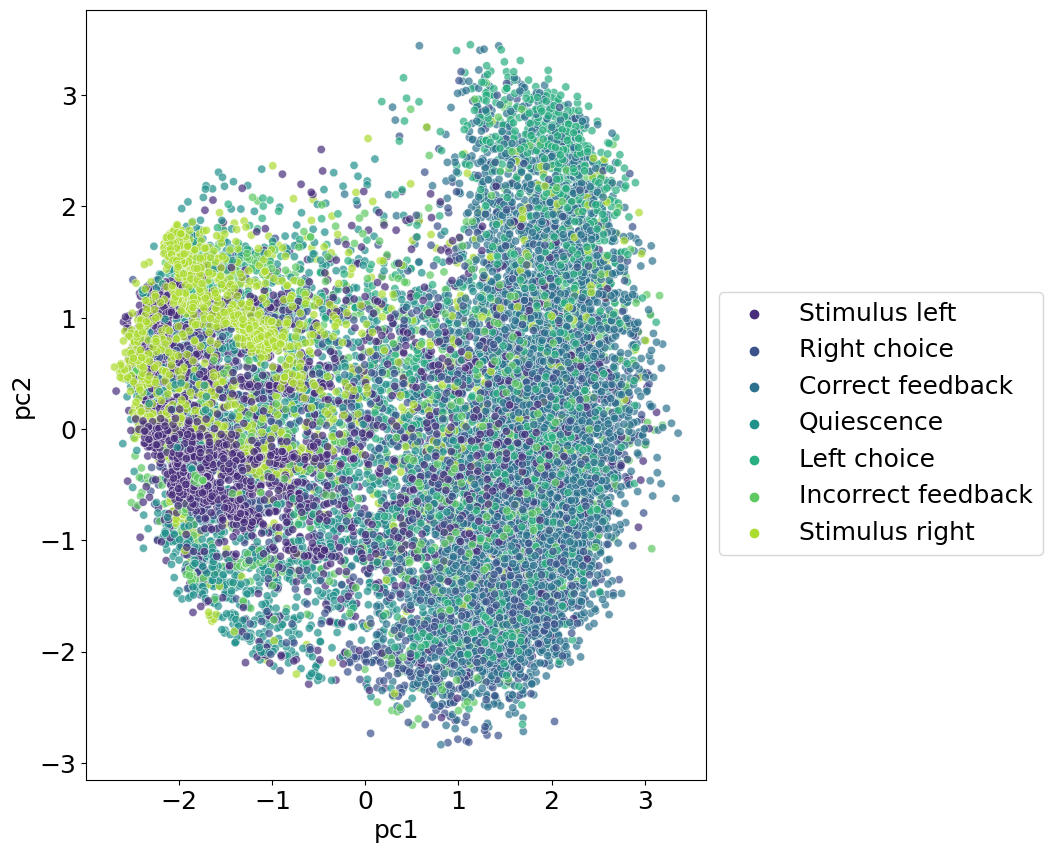

In [31]:
pairs = [['Stimulus right', 'Stimulus left'], ['Right choice', 'Left choice'], 
         ['Correct feedback', 'Incorrect feedback'], ['Quiescence', 'ITI'], 
         ['Stimulus left', 'Right choice', 'Correct feedback', 'ITI',
       'Quiescence', 'Left choice', 'Incorrect feedback',
       'Stimulus right']]

for pair in pairs:
    fig, axs = plt.subplots(figsize=[8, 10])
    use_data = augmented.loc[augmented['label'].isin(pair)]
    sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.7, hue='label', palette='viridis')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.65))


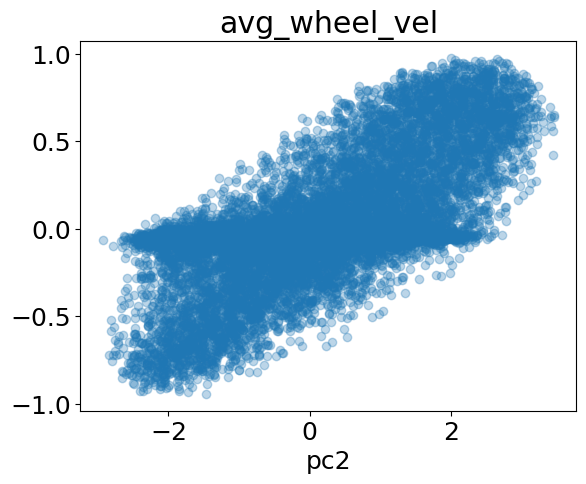

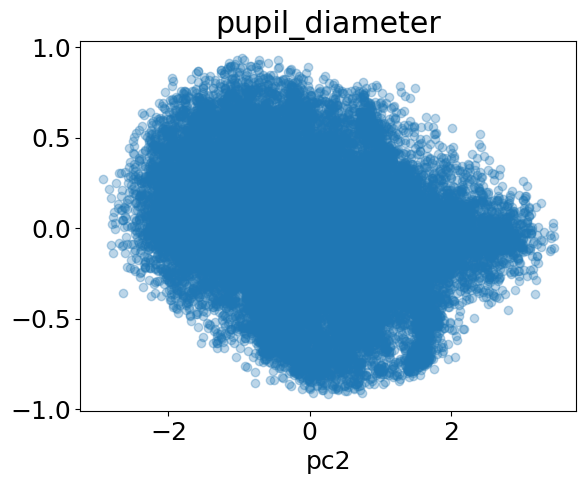

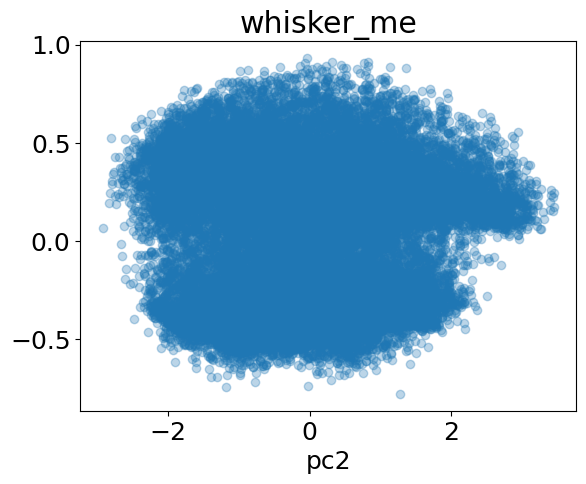

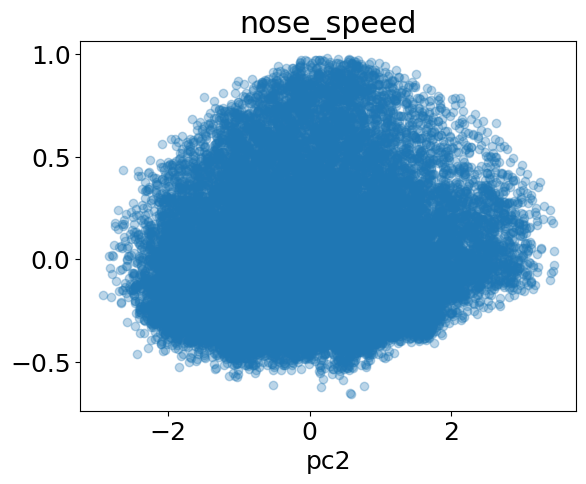

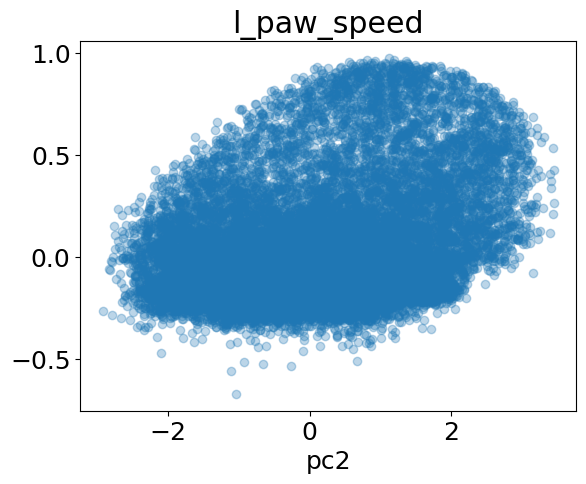

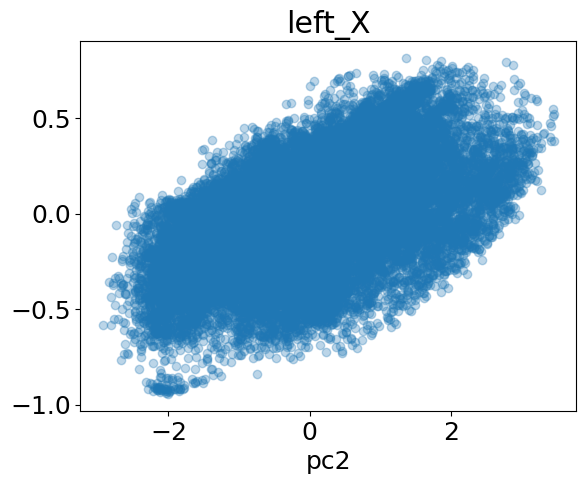

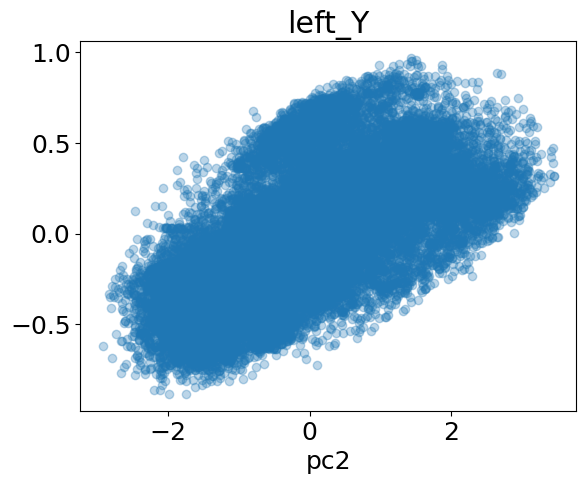

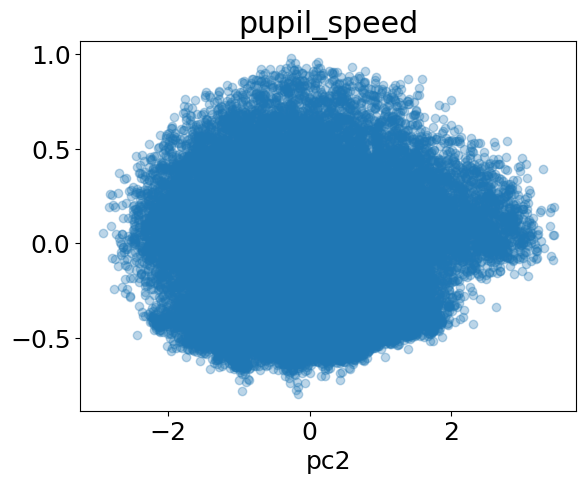

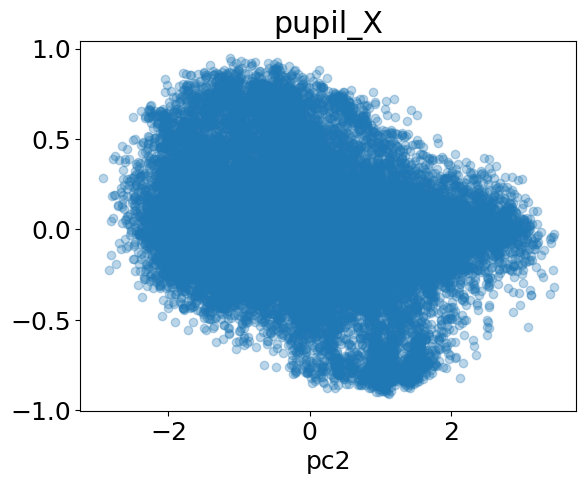

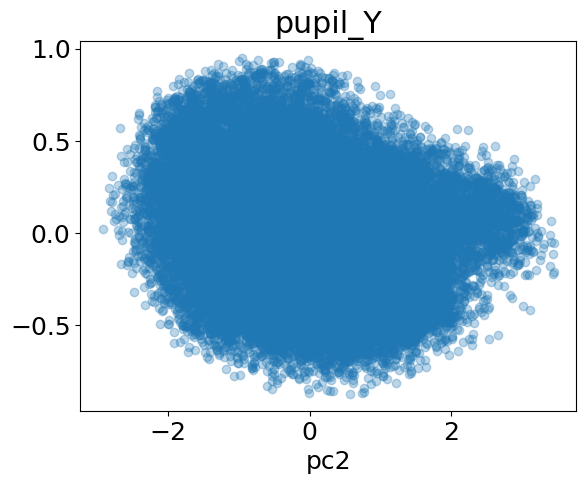

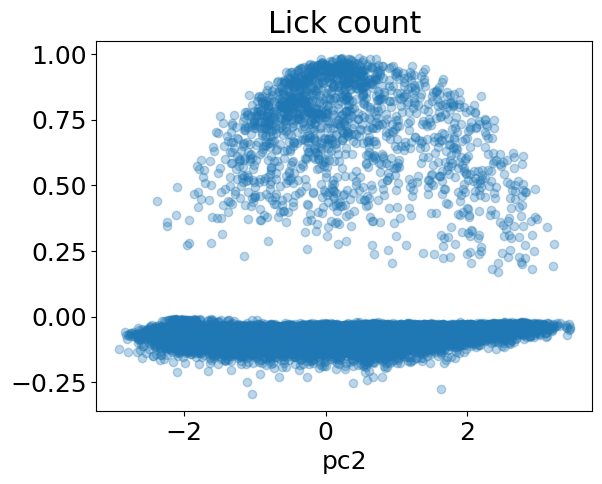

In [143]:
pc = 'pc2'
for v, var in enumerate(var_names):
    plt.scatter(np.array(augmented_data[pc]), X[:, v], alpha=0.3)
    plt.xlabel(pc)
    plt.title(var)
    plt.show()